In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import pandas as pd
import matplotlib as plt
import seaborn as sbn
import numpy as np
import warnings
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.model_selection import train_test_split,  GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, RidgeCV, ElasticNetCV, LinearRegression, LassoCV
from sklearn.model_selection import cross_val_score
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
from jupyterthemes import jtplot
jtplot.style()
warnings.filterwarnings('ignore')
%matplotlib inline

# Pre-processing using imputation

## Separating training and test data

In [3]:
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
df_train = pd.read_csv("train.csv")
df_train = df_train.drop('Id', axis = 1)
df_test = df_test.drop("Id", axis = 1)

#training data features
train_numerics = df_train.select_dtypes(include=[np.number])
#train_numerics = train_numerics.drop('SalePrice', axis = 1)
train_categorics = df_train.select_dtypes(include = ["object"])
print("There are", train_numerics.shape[1]," numeric features and", train_categorics.shape[1]," categorical features in the training data.")
#test data features
test_numerics = df_test.select_dtypes(include=[np.number])
test_categorics = df_test.select_dtypes(include = ["object"])
print("There are", test_numerics.shape[1]," numeric features and", test_categorics.shape[1]," categorical features in the test data.")

There are 37  numeric features and 43  categorical features in the training data.
There are 36  numeric features and 43  categorical features in the test data.


In [4]:
print(train_numerics.isna().sum().max())

259


## Searching for outliers

First we plot a correlation matrix for the first 10 most relevant features related to SalePrice.

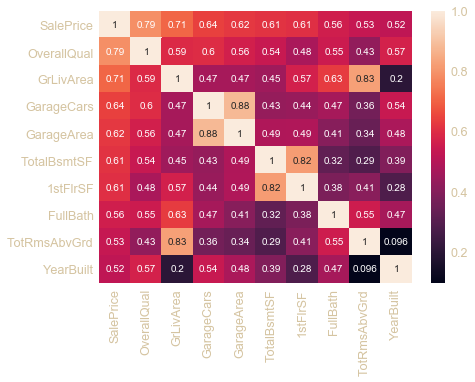

In [5]:
corrdata = train_numerics.corr()
cols = corrdata.nlargest(10,'SalePrice')['SalePrice'].index
cm = np.corrcoef(df_train[cols].values.T)
plt.pyplot.subplots(figsize=(7, 5))
sbn.heatmap(cm, annot = True, yticklabels = cols.values, xticklabels = cols.values);

The creator of the dataset suggests removing all GrLivArea rows with a value above 4000, so we will look into that first.

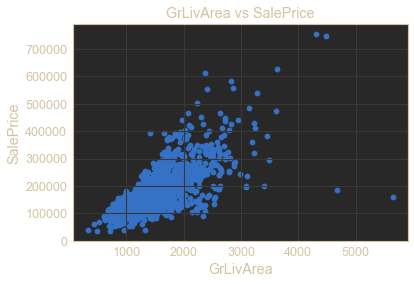

In [6]:
plt.pyplot.scatter(train_numerics.GrLivArea, train_numerics.SalePrice)
plt.pyplot.title("GrLivArea vs SalePrice")
plt.pyplot.xlabel("GrLivArea")
plt.pyplot.ylabel("SalePrice")
plt.pyplot.grid(True)
plt.pyplot.show()

In [7]:
train_numerics = train_numerics[train_numerics.GrLivArea < 4000]

## Transforming skewed training data

For this dataset we will be using the log(x+1) transform function because of 0 values as seen in previous plots. We transform the data so as to reduce the impact of outliers on our model.

In [8]:
train_numerics = np.log1p(train_numerics)

## Transforming skewed test data

In [9]:
#don't forget to do the same thing on the data set too
test_numerics = np.log1p(test_numerics)

## Handling dummy variables

Our models require numeric values, so we will be turning all categorical variables into dummy variables.

In [10]:
#papa bless stackoverflow https://datascience.stackexchange.com/questions/18956/different-number-of-features-in-train-vs-test
num = len(train_categorics)
dataset = pd.concat(objs = [train_categorics, test_categorics], axis = 0) 
dataset = pd.get_dummies(dataset)
train_categorics = dataset[:num]
test_categorics = dataset[num:]

## Joining the features

In [11]:
train_numerics = train_numerics.drop('SalePrice', axis = 1)
df_train = pd.concat([train_numerics, train_categorics], axis = 1)
df_test = pd.concat([test_numerics, test_categorics], axis = 1)

print("New number of training features ", df_train.shape[1])
print("New number of test features ", df_test.shape[1])

New number of training features  288
New number of test features  288


## Imputing numerical features

In [12]:
imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean') #replace null rows with the mean of its column
df_train[df_train.columns] = imputer.fit_transform(df_train)
df_train.isna().sum().max() #check if there is any missing data left in the train dataset

0

## Splitting data

In [13]:
y = np.log1p(train.SalePrice) #target
X = df_train
X_train,X_test,y_train,y_test = train_test_split(X,y, random_state = 420, test_size = 0.33) # split training data into training and validation data

In [14]:
df_test = df_test.fillna(0) # fill null values with 0

## Standardising data

In [15]:
scl = StandardScaler()

X_train[train_numerics.columns] = scl.fit_transform(X_train[train_numerics.columns])
X_test[test_numerics.columns] = scl.transform(X_test[test_numerics.columns])

scl_test = StandardScaler()

df_test[test_numerics.columns] = scl_test.fit_transform(df_test[test_numerics.columns]);

## Creating the model

In [16]:
scorer = make_scorer(mean_squared_error, greater_is_better  = False)
#function to calculate RMSE score on training data
def rmse_cv_train(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train, scoring = scorer, cv = 5))
    return rmse

#function to calculate RMSE score on training data
def rmse_cv_test(model):
    rmse = np.sqrt(-cross_val_score(model, X_test, y_test, scoring = scorer, cv = 5))
    return rmse

First we will try RandomForestRegressor as it's fast and accurate.

In [17]:
forest_model = RandomForestRegressor(n_estimators = 150)
forest_model.fit(X_train,y_train)


forest_pred = forest_model.predict(X_test)

print("RMSE with CV on training data is :", rmse_cv_train(forest_model).mean())

print("RMSE with CV on test data is :", rmse_cv_test(forest_model).mean())

RMSE with CV on training data is : 0.1468244299830165
RMSE with CV on test data is : 0.1760932125347185


## Regularized models

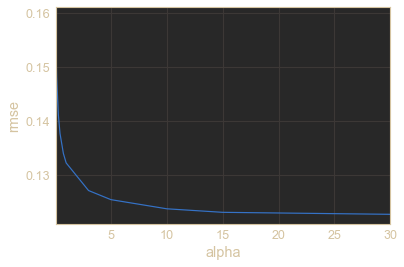

0.12263331717998942


In [18]:
alphas = [0.05, 0.10, 0.15, 0.3, 0.45, 0.75, 1, 3, 5, 10, 15, 30]
ridge = []
for alpha in alphas:
    ridge.append(rmse_cv_train(Ridge(alpha = alpha)).mean())
    
ridge = pd.Series(ridge, index = alphas)
ridge.plot()
plt.pyplot.xlabel("alpha")
plt.pyplot.ylabel("rmse")
plt.pyplot.show()
print(ridge.min())

In [19]:
alphas = np.logspace(-3, -1, 30)
lasso = LassoCV(alphas = alphas, cv = 5).fit(X_train, y_train)

print("RMSE on training data",rmse_cv_train(lasso).mean())
print("RMSE on test data",rmse_cv_test(lasso).mean())

RMSE on training data 0.12280689283663411
RMSE on test data 0.14253671135606336


In [20]:
xgb_model = xgb.XGBRegressor(n_estimators= 3000, max_depth=5, learning_rate = 0.01, objective ='reg:linear', min_child_weight = 3, n_thread = 4,
                             reg_alpha = alpha, subsample = 0.9, colsample_bytree = 0.8, scale_pos_weight = 1, gamma = 0)
xgb_model.fit(X_train, y_train)

print("RMSE on training data",rmse_cv_train(xgb_model).mean())
print("RMSE on test data",rmse_cv_test(xgb_model).mean())

RMSE on training data 0.19552237138488734
RMSE on test data 0.25774143335570815


## Making the prediction

In [21]:
prediction_xgb = xgb_model.predict(df_test)
prediction_lasso = lasso.predict(df_test)
prediction_final = np.expm1(prediction_lasso* 0.7 + prediction_xgb * 0.3)

print("Final prediction :", prediction_final[:10])


Final prediction : [120692.95060467 160476.50284863 185404.12711121 202807.05269628
 195134.95980454 175420.34135049 171901.93368106 167190.23209231
 197744.70420379 117822.53721895]


## Creating the submission file

In [22]:
submission = pd.DataFrame()
submission['Id'] = test.Id

submission['SalePrice'] = prediction_final

submission.to_csv('submission.csv', index = False)

In [23]:
submission.describe()

,Id,SalePrice
count,1459.000000,1459.000000
mean,2190.000000,177192.111804
std,421.321334,66261.682748
min,1461.000000,44372.977373
25%,1825.500000,130349.925734
50%,2190.000000,161130.907338
75%,2554.500000,213135.201375
max,2919.000000,527407.659289
